In [1]:
%matplotlib notebook
from helpers.helpers import read_results_alignment

import seaborn as sns
sns.set()

from helpers.geometry_helpers import make_avg_fragment_if_not_exists
from helpers.helpers import read_results_alignment
from helpers.plot_functions import plot_fragment_colored
from classes.Settings import Settings

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
import math

In [2]:
filenames = []
filenames.append(".\\results\\RNO2\\RNO2_CF_vdw.5\\RNO2_CF_vdw.5_aligned.csv")
filenames.append(".\\results\\RCOMe\\RCOMe_R2CO_vdw.5\\RCOMe_R2CO_vdw.5_aligned.csv")
filenames.append(".\\results\\RC6H5\\RC6H5_CF_vdw.5\\RC6H5_CF_vdw.5_aligned.csv")
filenames.append(".\\results\\RC6F5\\RC6F5_CF_vdw.5\\RC6F5_CF_vdw.5_aligned.csv")

avg_fragments = []
for filename in filenames:
    settings = Settings(filename)

    df = read_results_alignment(settings.get_aligned_csv_filename())
    avg_fragment = make_avg_fragment_if_not_exists(settings, df)
    avg_fragments.append(avg_fragment)

RNO2
RCOMe
Adding model CH3 group


<IPython.core.display.Javascript object>


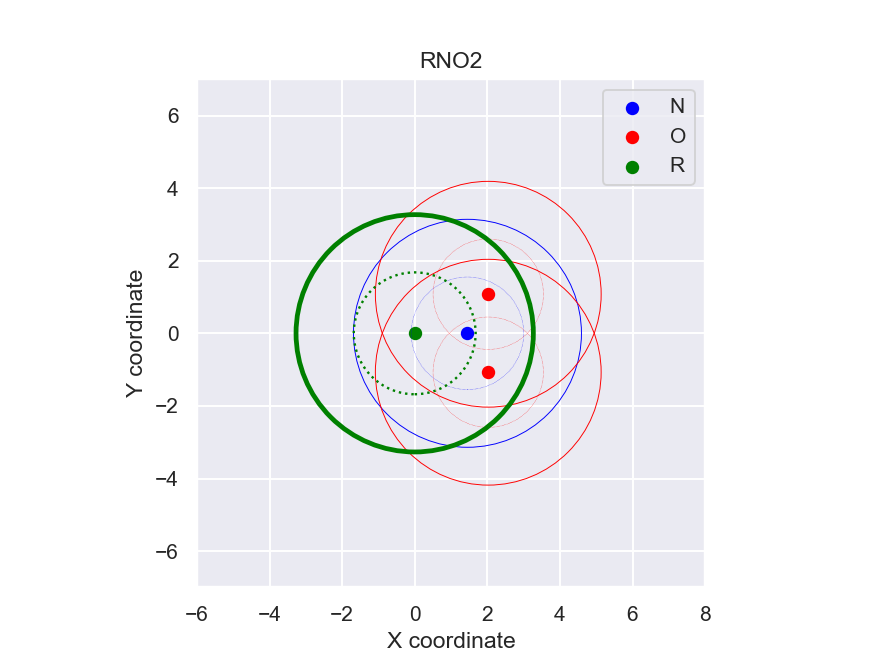

<IPython.core.display.Javascript object>


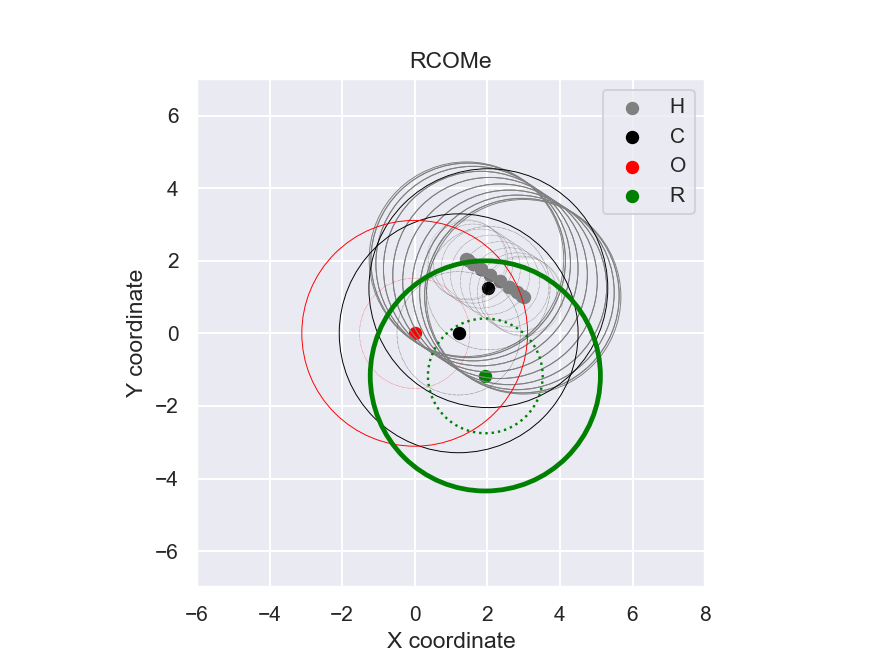

<IPython.core.display.Javascript object>


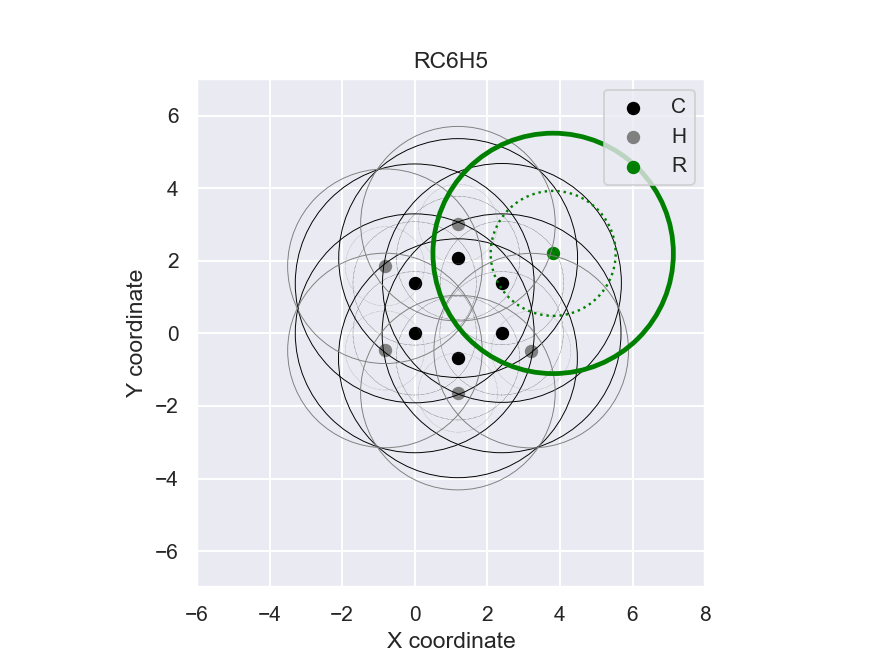

<IPython.core.display.Javascript object>


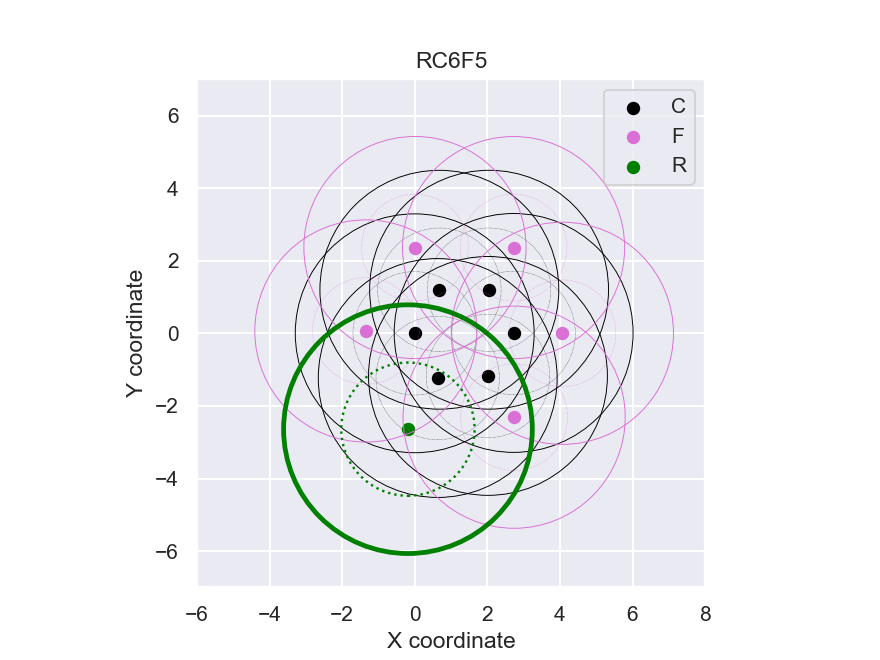

In [3]:
names = ['RNO2', 'RCOMe', 'RC6H5', 'RC6F5']

for name, avg_fragment in zip(names, avg_fragments):
    fig, ax = plt.subplots()
    plt.title(name)
    
    for _, atom in avg_fragment.iterrows():
        linewidth = .5
        # plot the (average of the) central group
        if 'R' in atom.atom_label:
            linewidth = 2.5
            color = 'green'
            label = 'R'
        elif 'H' in atom.atom_label:
            color = 'grey'
            label = 'H'
        elif 'O' in atom.atom_label:
            color='red'
            label = 'O'
        elif 'F' in atom.atom_label:
            color='orchid'
            label = 'F'
        elif 'N' in atom.atom_label:
            color='blue'
            label = 'N'
        else:
            color = 'black'
            label ='C'
            
        plt.scatter(atom.atom_x, atom.atom_y, color=color, label=label)

        draw_circle = plt.Circle((atom.atom_x, atom.atom_y), atom.vdw_radius, fill=False, color=color, 
                                  linewidth=linewidth*0.5, linestyle=':')

        ax.set_aspect(1)
        ax.add_artist(draw_circle)

        draw_circle = plt.Circle((atom.atom_x, atom.atom_y), atom.vdw_radius + 0.5 + 1.09, fill=False, 
                                  color=color, linewidth=linewidth)

        ax.set_aspect(1)
        ax.add_artist(draw_circle)

    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    
    plt.xlim(-6,8)
    plt.ylim(-7,7)
    
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    plt.legend(*zip(*unique))

    plt.savefig(name + '_overlap_R_volumes.png')
    plt.show()

In [4]:
from numba import jit
from numba import prange

def calculate_no_bins(minimum, maximum, resolution):
    """ Calculates the number of bins needed between a minimum and a maximum at a certain resolution.
        Returns the number of  bins, and the adjusted minimum and maximum to make the bins fit precisely. """

    bins_neg = math.ceil(abs(minimum + 0.5 * resolution)/resolution)
    bins_pos = math.ceil(abs(maximum - 0.5 * resolution)/resolution)

    minimum, maximum = -bins_neg * resolution, bins_pos * resolution

    # add one extra bin so we can put the origin in the middle of a bin
    no_bins = bins_neg + bins_pos + 1

    return no_bins, minimum, maximum


def prepare_df(df, settings):
    maxx, maxy, maxz = df.atom_x.max(), df.atom_y.max(), df.atom_z.max()
    minx, miny, minz = df.atom_x.min(), df.atom_y.min(), df.atom_z.min()

    no_bins_x, minx, maxx = calculate_no_bins(minx, maxx, settings.resolution)
    no_bins_y, miny, maxy = calculate_no_bins(miny, maxy, settings.resolution)
    no_bins_z, minz, maxz = calculate_no_bins(minz, maxz, settings.resolution)

    amount_bins = no_bins_x * no_bins_y * no_bins_z
    indices = [i for i in range(0, amount_bins)]

    bins = [np.linspace(minx, maxx, num=no_bins_x, endpoint=False),
            np.linspace(miny, maxy, num=no_bins_y, endpoint=False),
            np.linspace(minz, maxz, num=no_bins_z, endpoint=False)]

    df = add_boundaries_per_bin(bins, indices)
    df[settings.to_count_contact] = 0

    return df


def add_boundaries_per_bin(bins, indices):

    df = pd.DataFrame([], index=indices)

    bins_x, bins_y, bins_z = bins[0], bins[1], bins[2]

    xl, yl, zl = len(bins_x), len(bins_y), len(bins_z)

    xstart_list = np.repeat(bins_x, (yl * zl))
    ystart_list = list(np.repeat(bins_y, zl)) * xl
    zstart_list = list(bins_z) * (xl * yl)

    df["xstart"] = xstart_list
    df["ystart"] = ystart_list
    df["zstart"] = zstart_list

    df = df.apply(pd.to_numeric, downcast='float', errors='coerce')

    return df

@jit(nopython=True, parallel=True)
def calc_distances(in_vdw_volume, bin_coordinates, avg_f_p, indices, extra):

    for i in prange(len(indices)):
        idx = indices[i]

        bin_point = bin_coordinates[idx[0]]
        distance = np.sqrt(np.sum((bin_point - avg_f_p[:3])**2))

        if distance < avg_f_p[3] + extra:
            in_vdw_volume[idx] = 1

    return in_vdw_volume


def find_min_max_bounds(avg_fragment, extra):
    avg_fragment['minx'] = avg_fragment['atom_x'] - avg_fragment['vdw_radius'] - extra
    avg_fragment['miny'] = avg_fragment['atom_y'] - avg_fragment['vdw_radius'] - extra
    avg_fragment['minz'] = avg_fragment['atom_z'] - avg_fragment['vdw_radius'] - extra
    avg_fragment['maxx'] = avg_fragment['atom_x'] + avg_fragment['vdw_radius'] + extra
    avg_fragment['maxy'] = avg_fragment['atom_y'] + avg_fragment['vdw_radius'] + extra
    avg_fragment['maxz'] = avg_fragment['atom_z'] + avg_fragment['vdw_radius'] + extra

    return avg_fragment


def count_bins_in_vdw(avg_fragment, extra):
    """ Input: the coordinates of the average fragment, the resolution on which we are calculating and the radius
        of the contact group + 0.5.

        Output: dataframe with defined bins and whether they are in the volume or not, and the amount of bins that is
        in the vdw volume. """

    # 0.1 is accurate and semi-instantaneous calculation, see thesis
    resolution = 0.1

    avg_fragment = find_min_max_bounds(avg_fragment, extra)

    minx, miny, minz = avg_fragment['minx'].min(), avg_fragment['miny'].min(), avg_fragment['minz'].min()
    maxx, maxy, maxz = avg_fragment['maxx'].max(), avg_fragment['maxy'].max(), avg_fragment['maxz'].max()

    no_bins_x, minx, maxx = calculate_no_bins(minx, maxx, resolution)
    no_bins_y, miny, maxy = calculate_no_bins(miny, maxy, resolution)
    no_bins_z, minz, maxz = calculate_no_bins(minz, maxz, resolution)

    amount_bins = no_bins_x * no_bins_y * no_bins_z
    indices = [i for i in range(0, amount_bins)]

    bins = [np.linspace(minx, maxx, num=no_bins_x, endpoint=False),
            np.linspace(miny, maxy, num=no_bins_y, endpoint=False),
            np.linspace(minz, maxz, num=no_bins_z, endpoint=False)]

    df = add_boundaries_per_bin(bins, indices)

    # the bin counts as inside the vdw radius only if the center is in that radius
    df['x_center'] = df.xstart + 0.5 * resolution
    df['y_center'] = df.ystart + 0.5 * resolution
    df['z_center'] = df.zstart + 0.5 * resolution

    part_density = df[(df.x_center < maxx) & (df.x_center > minx) &
                      (df.y_center < maxy) & (df.y_center > miny) &
                      (df.z_center < maxz) & (df.z_center > minz)]

    bin_coordinates = np.transpose(np.array([part_density.x_center, part_density.y_center, part_density.z_center]))

    in_vdw_vol = np.zeros(len(df))

    for i, atom in avg_fragment.iterrows():
        indices = np.transpose(np.where(in_vdw_vol == 0))

        fragment_point = np.array([atom.atom_x, atom.atom_y, atom.atom_z, atom.vdw_radius])

        in_vdw_vol = calc_distances(in_vdw_vol, bin_coordinates, fragment_point, indices, extra)

    total = np.sum(in_vdw_vol)

    return total * resolution**3


def find_available_volume(avg_fragment, extra):
    # TODO: calculate this difference at once if you don't need the two separate anyways
    volume_max = count_bins_in_vdw(avg_fragment=avg_fragment, extra=extra)
    volume_central = count_bins_in_vdw(avg_fragment=avg_fragment, extra=0)

    return volume_max - volume_central


In [6]:
for name, avg_fragment in zip(names, avg_fragments):
    print('\n' + name)
    tolerance = 0.5
    vdw_contact = 1.09
    extra = tolerance + vdw_contact
    
    avg_fragment_without_R = avg_fragment[~avg_fragment.atom_label.str.contains("R")].copy()
    only_R = avg_fragment[avg_fragment.atom_label.str.contains("R")].copy()
    
    volume = find_available_volume(avg_fragment, extra=extra)
    print('with R                        :', round(volume, 1))
    
    # R door de helft
    volume_max = count_bins_in_vdw(avg_fragment=avg_fragment, extra=extra)
    volume_central = count_bins_in_vdw(avg_fragment=avg_fragment, extra=0)
    
    volume_R_min = count_bins_in_vdw(avg_fragment=only_R, extra=0)
    volume_R_max = count_bins_in_vdw(avg_fragment=only_R, extra=extra)
    
    volume2 = (volume_max - volume_R_max/2) - (volume_central - volume_R_min/2)
    percent1 = (volume2 - volume) / volume * 100

    print('with half R                   :', round(volume2, 1), '    ', round(abs(percent1), 2))
    
    # wel bij min, niet bij max
    volume_max = count_bins_in_vdw(avg_fragment=avg_fragment_without_R, extra=extra)
    volume_central = count_bins_in_vdw(avg_fragment=avg_fragment, extra=0)
    
    volume3 = volume_max - volume_central
    percent2 = (volume3 - volume) / volume * 100

    print('with R in min, not in max     :', round(volume3, 1), '    ', round(abs(percent2), 2))
    
    
    # half R bij min, niet bij max:
    volume_max = count_bins_in_vdw(avg_fragment=avg_fragment_without_R, extra=extra)
    volume_central = count_bins_in_vdw(avg_fragment=avg_fragment, extra=0)
    
    volume_R_min = count_bins_in_vdw(avg_fragment=only_R, extra=0)
    
    volume4 = (volume_max) - (volume_central - volume_R_min/2)
    percent3 = (volume4 - volume) / volume * 100

    print('with half R in min, not in max:', round(volume4, 1), '    ', round(abs(percent3), 2))    


RNO2
with R                        : 210.1
with half R                   : 144.5      31.25
with R in min, not in max     : 159.2      24.27
with half R in min, not in max: 170.0      19.1

RCOMe
with R                        : 235.7
with half R                   : 174.8      25.85
with R in min, not in max     : 201.4      14.55
with half R in min, not in max: 210.4      10.73

RC6H5
with R                        : 307.5
with half R                   : 239.4      22.13
with R in min, not in max     : 254.5      17.21
with half R in min, not in max: 265.9      13.51

RC6F5
with R                        : 386.0
with half R                   : 311.9      19.18
with R in min, not in max     : 330.7      14.32
with half R in min, not in max: 344.6      10.71
